Starting MATLAB Engine...
MATLAB Engine started.
Loaded experimental data shapes:
  time_exp: (8456,)
  voltage_exp: (8456,)
  exp_hgr: (8456,)
Generating data from P2D model: 1/800
Generating data from P2D model: 2/800
Generating data from P2D model: 3/800
Generating data from P2D model: 4/800
Generating data from P2D model: 5/800
Generating data from P2D model: 6/800
Generating data from P2D model: 7/800
Generating data from P2D model: 8/800
Generating data from P2D model: 9/800
Generating data from P2D model: 10/800
Generating data from P2D model: 11/800
Generating data from P2D model: 12/800
Generating data from P2D model: 13/800
Generating data from P2D model: 14/800
Generating data from P2D model: 15/800
Generating data from P2D model: 16/800
Generating data from P2D model: 17/800
Generating data from P2D model: 18/800
Generating data from P2D model: 19/800
Generating data from P2D model: 20/800
Generating data from P2D model: 21/800
Generating data from P2D model: 22/800
Generat

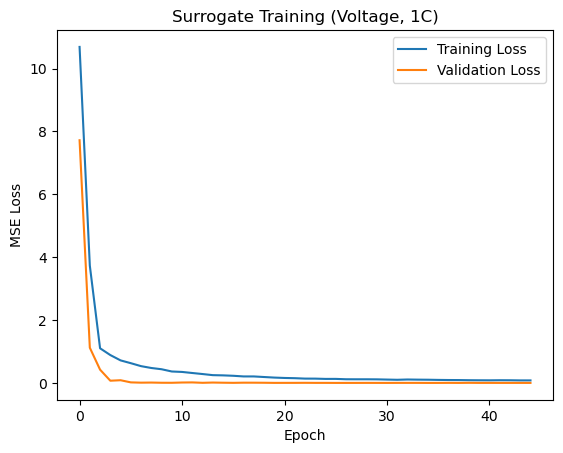

/var/folders/91/2bk9sgm943xb_ng_sdcgxk_r0000gn/T/ipykernel_26692/1629937393.py:189: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(



RESULT OF PARAMETER IDENTIFICATION:
  Success: True
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Best Params: [2.52500000e-09 2.52487285e-09 1.56672431e-05 4.50000000e-01
 1.55000000e-04 1.07045640e-04 1.10000000e+02 5.50000000e-01
 3.98296046e-04 2.49956590e-04]
  Best SSE: 253.1645456822906


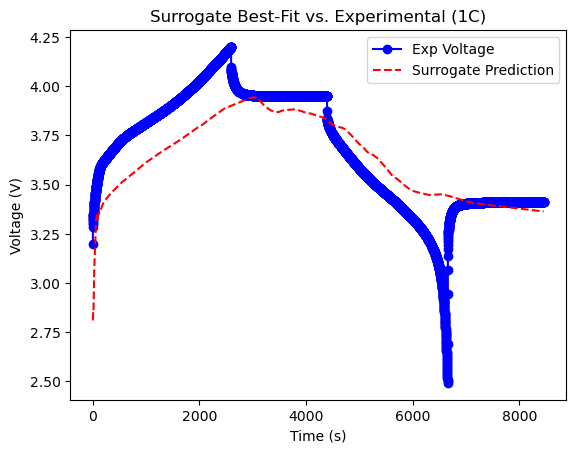

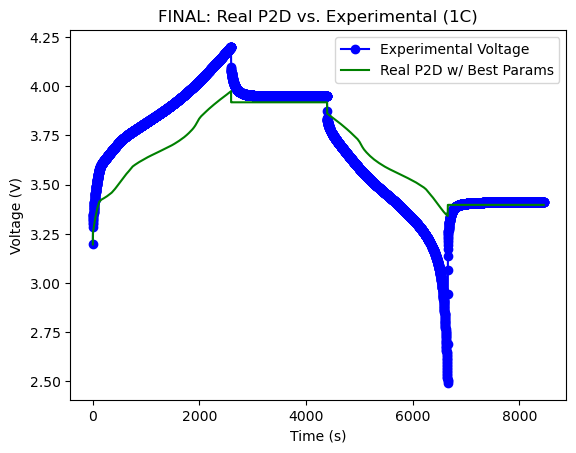

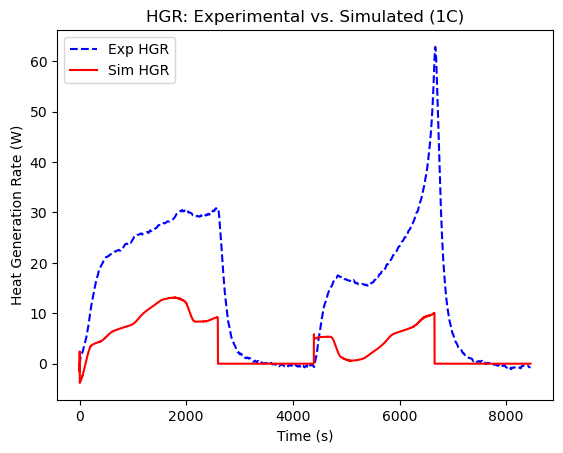

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   scipy.optimize import minimize
from   scipy.io import loadmat
import matlab.engine  # for calling MATLAB

# matlab engine
print("Starting MATLAB Engine...")
eng = matlab.engine.start_matlab()
print("MATLAB Engine started.")

# experimental data 
mat_file = "/Users/nibrasaamir/Desktop/hashim/mat/GME101_1C_EE_25oC_clean.mat"
data_dict = loadmat(mat_file)
Data_exp  = data_dict['Data_exp']

time_exp    = Data_exp['Time_S'][0,0].flatten()       # array of time in seconds
voltage_exp = Data_exp['Voltage_V'][0,0].flatten()    # array of voltage in volts
exp_hgr     = Data_exp['Total_HGR_W'][0,0].flatten()  # array of HGR in Watts 

print("Loaded experimental data shapes:")
print("  time_exp:", time_exp.shape)
print("  voltage_exp:", voltage_exp.shape)
print("  exp_hgr:", exp_hgr.shape)

# calling p2d model from matlab 
def simulate_p2d_model_full(matlab_engine, param_vec, data_file, crate):
    """
    Calls MAIN_I_ROM_V3_1_1_PE in MATLAB (nargout=1) and returns:
      - t_sim: time array
      - V_sim: voltage array
      - hgr_sim: total heat generation rate array (Heat_tot)
    """
    # Convert params -> MATLAB double
    mat_params = matlab.double(list(param_vec), size=(1, len(param_vec)))
    
    # Load data_file in MATLAB
    matlab_engine.eval(f"load('{data_file}')", nargout=0)

    # Call the P2D model
    Simdata = matlab_engine.MAIN_I_ROM_V3_1_1_PE(
        matlab_engine.workspace['Data_exp'], 
        mat_params, 
        crate,
        nargout=1
    )

    # Extract time, voltage, heat
    t_sim    = np.array(Simdata["t"]).flatten()
    V_sim    = np.array(Simdata["Vt"]).flatten()
    hgr_sim  = np.array(Simdata["Heat_tot"]).flatten() 

    return t_sim, V_sim, hgr_sim

# generating training data using the p2d model
range_lower = np.array([0.5e-10, 0.5e-10, 0.5e-6,  0.45, 1e-5,  1e-5,  105,   0.50, 100e-6,  100e-6])
range_upper = np.array([5e-9,    5e-9,    5e-5,   0.60, 3e-4,  2e-4,  115,   0.60, 400e-6,  400e-6])
param_dim   = len(range_lower)

N_synth     = 800  # Increase for better accuracy
data_file_1C= "/Users/nibrasaamir/Desktop/hashim/mat/GME101_1C_EE_25oC_clean.mat"
crate_value = 1.0  # 1C

X_synth = []
y_synth = []

for i in range(N_synth):
    print(f"Generating data from P2D model: {i+1}/{N_synth}")

    # Sample param vector in [range_lower, range_upper]
    p_rand = np.array([
        np.random.uniform(range_lower[j], range_upper[j])
        for j in range(param_dim)
    ])

    # Simulate the P2D model (time, voltage, hgr)
    t_sim, V_sim, hgr_sim = simulate_p2d_model_full(
        eng, p_rand, data_file_1C, crate_value
    )

    # If any voltage is complex, skip
    if np.iscomplexobj(V_sim):
        print("Skipping invalid param set (complex voltage). Params:", p_rand)
        continue

    # Sample a few points from the curve to reduce data size
    if len(t_sim) < 5:
        sample_indices = np.arange(len(t_sim))
    else:
        sample_indices = np.random.choice(len(t_sim), size=5, replace=False)

    for idx in sample_indices:
        # Input features: [params..., time]
        x_i = np.concatenate([p_rand, [t_sim[idx]]])
        # Output: voltage
        y_i = V_sim[idx]

        X_synth.append(x_i)
        y_synth.append(y_i)

X_synth = np.array(X_synth, dtype=np.float64)
y_synth = np.array(y_synth, dtype=np.float64).reshape(-1, 1)

print("\nFinal training data for surrogate (voltage).")
print("  X_synth.shape:", X_synth.shape)
print("  y_synth.shape:", y_synth.shape)

# neural network surrogate
model = keras.Sequential([
    keras.Input(shape=(param_dim + 1,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1) 
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer    = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

if X_synth.shape[0] == 0:
    print("\nNo valid training samples found. Refine parameter ranges or solver code!")
    model = None
else:
    history = model.fit(
        X_synth, y_synth,
        epochs=200,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopper, lr_reducer],
        verbose=1
    )

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Surrogate Training (Voltage, 1C)")
    plt.legend()
    plt.show()

# indentifying the parameters (minimize SSE vs. experimental voltage)
if model is not None:
    def objective_function(params):
        params_clipped = np.clip(params, range_lower, range_upper)
        n_points = len(time_exp)
        param_tile = np.repeat(params_clipped.reshape(1, -1), n_points, axis=0)
        input_nn   = np.concatenate([param_tile, time_exp.reshape(-1,1)], axis=1)
        v_pred     = model.predict(input_nn, verbose=0).flatten()
        return np.sum((voltage_exp - v_pred)**2)

    initial_guess = 0.5*(range_lower + range_upper)
    bounds        = list(zip(range_lower, range_upper))

    result = minimize(
        fun=objective_function,
        x0=initial_guess,
        bounds=bounds,
        method='TNC',
        options={'maxiter': 300}
    )

    best_params = result.x
    best_sse    = result.fun

    print("\nRESULT OF PARAMETER IDENTIFICATION:")
    print("  Success:", result.success)
    print("  Message:", result.message)
    print("  Best Params:", best_params)
    print("  Best SSE:", best_sse)

    # Compare Surrogate Prediction vs. Experimental (Voltage)
    param_mat   = np.repeat(best_params.reshape(1, -1), len(time_exp), axis=0)
    input_nn    = np.concatenate([param_mat, time_exp.reshape(-1,1)], axis=1)
    v_pred_best = model.predict(input_nn, verbose=0).flatten()

    plt.figure()
    plt.plot(time_exp, voltage_exp, 'bo-', label='Exp Voltage')
    plt.plot(time_exp, v_pred_best, 'r--', label='Surrogate Prediction')
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("Surrogate Best-Fit vs. Experimental (1C)")
    plt.legend()
    plt.show()

    # Full call returning (t_sim, V_sim, hgr_sim)
    # p2d model and HGR
    t_sim_final, V_sim_final, hgr_sim_final = simulate_p2d_model_full(
        eng, best_params, data_file_1C, crate_value
    )

    # Plot final voltage comparison
    plt.figure()
    plt.plot(time_exp, voltage_exp, 'bo-', label='Experimental Voltage')
    plt.plot(t_sim_final, V_sim_final, 'g-', label='Real P2D w/ Best Params')
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("FINAL: Real P2D vs. Experimental (1C)")
    plt.legend()
    plt.show()

    # Plot HGR comparison
    plt.figure()
    plt.plot(time_exp, exp_hgr, 'b--', label='Exp HGR')
    plt.plot(t_sim_final, hgr_sim_final, 'r-', label='Sim HGR')
    plt.xlabel("Time (s)")
    plt.ylabel("Heat Generation Rate (W)")
    plt.title("HGR: Experimental vs. Simulated (1C)")
    plt.legend()
    plt.show()

eng.quit()
